In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation
from numpy import *
from random import random
import numpy as np
%matplotlib notebook
%load_ext Cython

In [3]:
%%cython
cimport cython

from random import random
import numpy as np
cimport numpy as np

from libc.math cimport exp, sin, cos, sqrt, M_PI

cdef class Particle(object):
    cdef public float x, y, vx, vy, dt, m
    def __init__(self, float x0, float y0, float vx0, float vy0, float m):
        self.x = x0
        self.y = y0

        self.vx = vx0
        self.vy = vy0
        
        self.m = m
        self.dt = 0.005
    
    cdef float vtotal, vmax
    cpdef _change_velocity(self, float dvx, float dvy):
        vmax = 5.
        self.vx += dvx
        self.vy += dvy
        vtotal = sqrt(self.vx**2 + self.vy**2)
        if vtotal > vmax:
            self.vx = self.vx * vmax/vtotal
            self.vy = self.vy * vmax/vtotal
            
    cpdef _get_vtotal(self):
        return sqrt(self.vx**2 + self.vy**2)

    cpdef step_particle(self):
        self.x += self.vx * self.dt
        self.y += self.vy * self.dt

cdef class RedParticle(Particle):
    def __init__(self, float x0, float y0, float vx0, float vy0, float m):
        super().__init__(x0, y0, vx0, vy0, m)
        
cdef class BlueParticle(Particle):
    def __init__(self, float x0, float y0, float vx0, float vy0, float m):
        super().__init__(x0, y0, vx0, vy0, m)

cdef class Ensemble(object):
    cdef int n
    cdef float vseed, x0, y0, vx0, vy0, x_bound0, x_bound1, y_bound0, y_bound1, drag_coeff, v_in, C_blue, C_red
    cdef list particle_array
    cdef public int nblue, nred
    cdef public np.float64_t[:,:] p_array, v_array
    @cython.boundscheck(False)
    @cython.wraparound(False)
    def __cinit__(self, int nblue, int nred, 
                  float x_bound0, float x_bound1, float y_bound0, float y_bound1, 
                  drag_coeff=0.2, v_in=0.2, C_blue=0.001, C_red=None):
        self.n = nblue + nred
        self.nblue = nblue
        self.nred = nred
        self.drag_coeff = drag_coeff
        self.C_blue = C_blue
        if C_red is None: self.C_red = C_blue
        else: self.C_red = C_red
        self.x_bound0 = x_bound0
        self.x_bound1 = x_bound1
        self.y_bound0 = y_bound0
        self.y_bound1 = y_bound1
        self.particle_array = []
        cdef int i
        for i in range(self.n):
            x0 = x_bound0 + (x_bound1 - x_bound0)*random()
            y0 = y_bound0 + (y_bound1 - y_bound0)*random()
            vseed = random()
            vx0 = v_in*cos(2*M_PI*vseed)
            vy0 = v_in*sin(2*M_PI*vseed)
            if i < nblue:
                self.particle_array.append(BlueParticle(x0, y0, vx0, vy0, 1))
            if i >= nblue:
                self.particle_array.append(RedParticle(x0, y0, vx0, vy0, 1))
        
        self.p_array = np.zeros((self.n, 2), float)
        for i in range(self.n):
            self.p_array[i,0] = self.particle_array[i].x
            self.p_array[i,1] = self.particle_array[i].y
    
        self.v_array = np.zeros((self.n, 2), float)
        for i in range(self.n):
            self.v_array[i,0] = self.particle_array[i].vx
            self.v_array[i,1] = self.particle_array[i].vy

    cdef float dt, ep, sig, dx, dy, sep_ij, sdr, l_j_potential, dvx, dvy
    @cython.boundscheck(False)
    @cython.wraparound(False)        
    cpdef _velocity_update(self): #updating velocities using the lennard-jones potential
        dt = self.particle_array[0].dt
        ep = 0.01 # strength of LJ interactions
        sig = 0.3 # length scale of LJ interactions
        cdef int i, j
        for i in range(self.n):
            for j in range(i+1, self.n): # no double counting or self counting
                dx = self.p_array[i,0] - self.p_array[j,0] # x dist. btwn m1/m2
                dy = self.p_array[i,1] - self.p_array[j,1] # y dist. btwn m1/m2
                sep_ij = sqrt(dx*dx + dy*dy)
                
                if sep_ij <= 2.*sig: #reduces the amount of interactions being evaluated
                    sdr = (sig / sep_ij)**6
                    l_j_potential = 24. * ep/sep_ij * (-2.*sdr**2 + sdr)
                    dvx = -dx/sep_ij * l_j_potential * dt
                    dvy = -dy/sep_ij * l_j_potential * dt

                    self.particle_array[i]._change_velocity(dvx,dvy)
                    self.particle_array[j]._change_velocity(-dvx,-dvy)
                    
                    #couloumbic interactions: note the longer range and that they don't exist if too close
                if (sep_ij >= 0.75*sig) and (sep_ij <= 4.*sig):
                    if i < self.nblue and j < self.nblue:
                        coul_attr = 4 * self.C_blue/sep_ij**6 * dt #represents an attractive dipole-dipole interaction
                    if i >= self.nblue and j >= self.nblue:
                        coul_attr = 4 * self.C_red /sep_ij**6 * dt
                    dvx = -dx * coul_attr
                    dvy = -dy * coul_attr
                    self.particle_array[i]._change_velocity(dvx,dvy)
                    self.particle_array[j]._change_velocity(-dvx,-dvy)
        
        # drag so there isn't infinite energy
        for i in range(self.n):
            drag_x = self.drag_coeff * self.particle_array[i].vx * dt
            drag_y = self.drag_coeff * self.particle_array[i].vy * dt
            self.particle_array[i]._change_velocity(-drag_x, -drag_y)
    
    @cython.boundscheck(False)
    @cython.wraparound(False)
    cpdef _time_step(self):
        cdef float eps
        eps = 0.01
        for i in range(self.n):
            m = self.particle_array[i]
            
            # particle boundary crossings
            if m.x <= self.x_bound0:
                m.x = self.x_bound0
                m.vx = -m.vx
                self.v_array[i,0] = self.particle_array[i].vx
            if m.x >= self.x_bound1:
                m.x = self.x_bound1
                m.vx = -m.vx
                self.v_array[i,0] = self.particle_array[i].vx
            if m.y <= self.y_bound0:
                m.y = self.y_bound0
                m.vy = -m.vy
                self.v_array[i,1] = self.particle_array[i].vy
            if m.y >= self.y_bound1:
                m.y = self.y_bound1
                m.vy = -m.vy
                self.v_array[i,1] = self.particle_array[i].vy
           
            m.step_particle()
            

    @cython.boundscheck(False)
    @cython.wraparound(False)                
    cpdef _set_p_array(self):
        cdef int i
        for i in range(self.n):
            self.p_array[i,0] = self.particle_array[i].x
            self.p_array[i,1] = self.particle_array[i].y

    cpdef _get_p_array(self):
        return self.p_array

    @cython.boundscheck(False)
    @cython.wraparound(False)
    cpdef _get_velocity_data(self):
        cdef np.float64_t[:] velocities = np.zeros(self.n, float)
        for i in range(self.n):
            velocities[i] = self.particle_array[i]._get_vtotal()
        return velocities

<IPython.core.display.Javascript object>


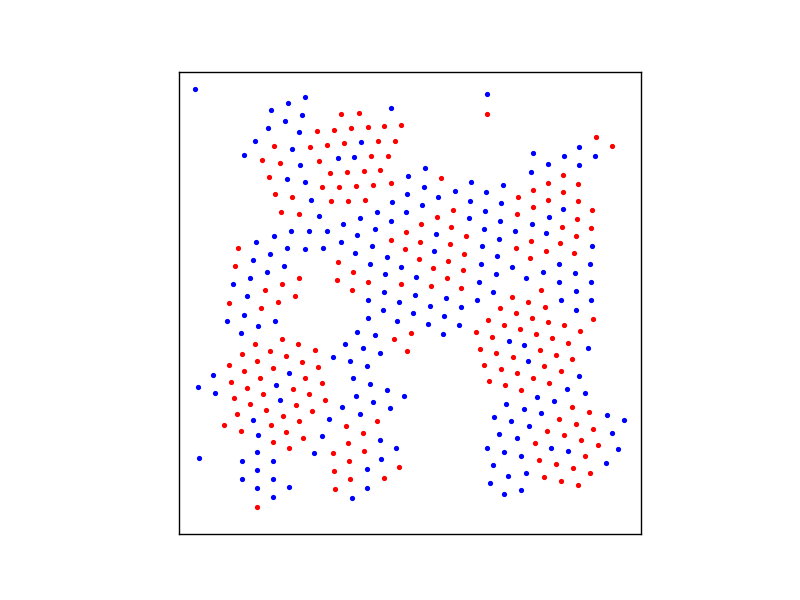

In [21]:
boxbound = 8.

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(0.,boxbound), ylim=(0.,boxbound))
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

# blue/redparticles hold the locations of the particles
blueparticles, = ax.plot([], [], 'bo', markersize=2)
redparticles, = ax.plot([], [], 'ro', markersize=2)
en = Ensemble(200, 200, 
              0., boxbound, 
              0., boxbound, 
              drag_coeff=0.9, v_in=0.4, C_blue=0.0002, C_red=0.0002)

def init():
    bxpoints = en.p_array[:en.nblue,0]
    bypoints = en.p_array[:en.nblue,1]
    blueparticles.set_data(bxpoints, bypoints)
    rxpoints = en.p_array[en.nblue:,0]
    rypoints = en.p_array[en.nblue:,1]
    redparticles.set_data(rxpoints, rypoints)
    return blueparticles, redparticles

def animate(i):
    for i in range(4):
        en._velocity_update()
        en._time_step()
        en._set_p_array()
    bxpoints = en.p_array[:en.nblue,0]
    bypoints = en.p_array[:en.nblue,1]
    blueparticles.set_data(bxpoints, bypoints)
    rxpoints = en.p_array[en.nblue:,0]
    rypoints = en.p_array[en.nblue:,1]
    redparticles.set_data(rxpoints, rypoints)
    return blueparticles, redparticles

anim = animation.FuncAnimation(fig, animate, frames=3000, init_func=init)

import matplotlib as mpl
mpl.rcParams['animation.ffmpeg_path'] = r'C:\\Users\\jackm\\Desktop\\ffmpeg\\bin\\ffmpeg.exe'

f = r"c://Users/jackm/Desktop/cythonLJ400particles.mp4" 
writermp4 = animation.FFMpegWriter(fps=40)
anim.save(f, writer=writermp4)

In [23]:
%timeit Ensemble(100, 100, 0., 3., 0., 3.)._velocity_update()
# pure python: 78.4 ms ± 1.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

4.32 ms ± 109 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
import matplotlib as mpl
mpl.rcParams['animation.ffmpeg_path'] = r'C:\\Users\\jackm\\Desktop\\ffmpeg\\bin\\ffmpeg.exe'

f = r"c://Users/jackm/Desktop/cythonLJbluered2.mp4" 
writermp4 = animation.FFMpegWriter(fps=60)
anim.save(f, writer=writermp4)